In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.patches as mpatches
import plot_utils
import scipy
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.metrics import r2_score

In [2]:
df_eval = pd.read_csv("EVAL_RESULTS_13Jan2023.csv")
df_test = pd.read_csv("TEST_RESULTS_13Jan2023.csv")

In [3]:
#
df_eval = df_eval.reset_index(drop=True)
print(df_eval.columns)

#
bin_ub = np.percentile(sorted(df_eval.loc[:, 'FLOPS Hoffman total'].values / 10**14), [i for i in range(0, 101, 5)])
#print(bin_ub)

#
bin_ub_new = []
prev_ub = 0
for ub_idx, ub_i in enumerate(bin_ub):
    if ub_idx in [0, 1, 2]:
        step_ = ((ub_i - prev_ub) / 5) if ub_idx == 2 else ((ub_i - prev_ub) / 10)
        bin_ub_new += list(np.arange(prev_ub, ub_i, step_))
    
    if ub_idx == 2:
        bin_ub_new.append(ub_i)
    
    prev_ub = ub_i
    

#
bin_ub_new = list(bin_ub_new) + list(bin_ub[2:])
#print(bin_ub_new)

#
bin_ub = bin_ub_new

Index(['Unnamed: 0', 'Unnamed: 0.1', 'eval/perplexity', 'eval/loss',
       'eval/step', 'eval/epoch', 'eval/batch_idx', 'eval/updates',
       'test/perplexity', 'test/loss', 'Embedding parameters',
       'Non-embedding parameters', 'Total parameters', 'run_name',
       'embedding_size', 'hidden_size', 'intermediate_size',
       'num_attention_heads', 'num_hidden_layers', 'Experiment type',
       'FLOPS Hoffman per sequence', 'FLOPS Hoffman total',
       'FLOPS Kaplan per sequence', 'FLOPS Kaplan total', 'Tokens'],
      dtype='object')


In [4]:
df_eval["FLOP bins"] = -1
for val_idx, val in enumerate(df_eval.loc[:, 'FLOPS Hoffman total'].values):
    val = val / 10**14
    ub_prev = 0
    for ub_idx, ub_ in enumerate(bin_ub[1:]):
        if ub_prev < val <= ub_:
            df_eval.loc[val_idx, "FLOP bins"] = ub_idx
            break
        else:
            ub_prev = ub_
    
df_eval["FLOP bins"] = df_eval["FLOP bins"].astype(str)

#
arg_min = []
for bin_ in df_eval.groupby(["FLOP bins"]).count().index:
    df_i = df_eval.loc[df_eval.loc[:, 'FLOP bins'] == bin_, :]
    df_i = df_i.sort_values(by=["eval/perplexity"], ascending=True)
    arg_min.append(df_i.index.tolist()[0])

#
df_arg_min = df_eval.loc[arg_min, :]
df_arg_min.to_csv("COMPUTE_OPTIMAL_RESULTS_13Jan2023.csv")

Text(0, 0.5, 'Perplexity on development set')

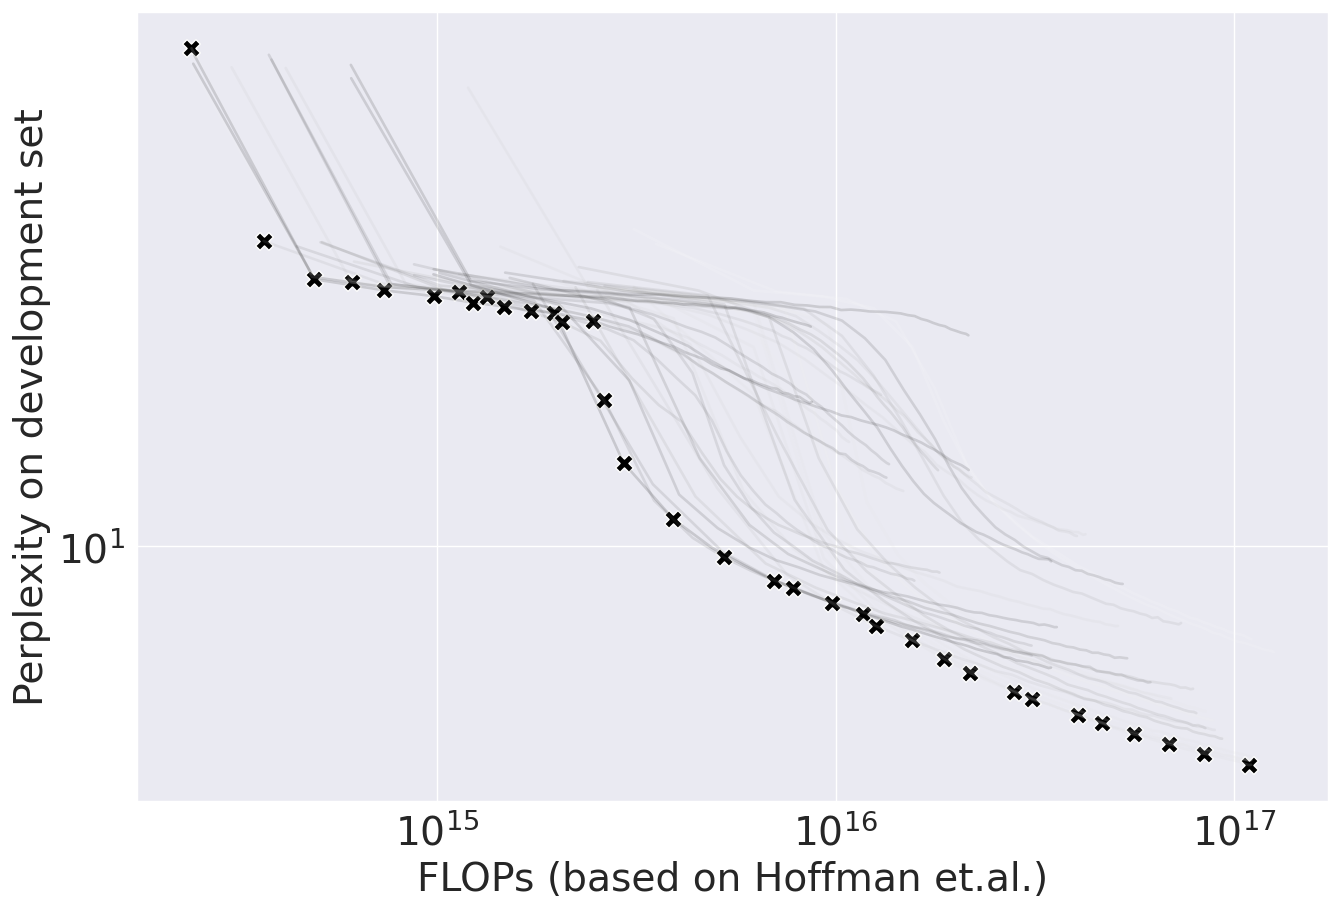

In [5]:
#
plt.rcParams.update({'font.size': 22})
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 8), dpi=128)
#ax.set_ylim(10**7, 10**13)
#ax.set_xlim(10**15, 10**13)
ax.set(xscale="log", yscale="log")
sns.scatterplot(
    data=df_arg_min,
    x="FLOPS Hoffman total",
    y="eval/perplexity",
    s=100,
    #linewidth=0,
    marker="X",
    color="black",
    #lw=4,
    #alpha=0.7,
    #ax=ax, 
)
sns.lineplot(
    data=df_eval,
    x="FLOPS Hoffman total",
    y="eval/perplexity",
    hue="run_name",
    palette="Greys",
    #s=10,
    #linewidth=0,
    #marker="X",
    #color="black",
    #lw=4,
    alpha=0.15,
    #ax=ax, 
    legend=False,
)

plt.xlabel("FLOPs (based on Hoffman et.al.)")
plt.ylabel("Perplexity on development set")
#plt.savefig("./PLOTS/FLOPs_vs_PPL_loglog.jpg")

#

In [6]:
df_arg_min.shape

(34, 26)

In [34]:
def power_curve(x, b):
    return np.multiply(1, np.power(x, b))

def line_curve(x, m, c):
    return np.multiply(-1*m, x) + c

In [35]:
tokens_ = df_arg_min.loc[:, "Tokens"].values
size_ = df_arg_min.loc[:, "Total parameters"].values
flops = df_arg_min.loc[:, "FLOPS Hoffman total"].values
loss_ = df_arg_min.loc[:, "eval/loss"].values
ppl_ = df_arg_min.loc[:, "eval/perplexity"].values

In [38]:
def df_viz_fit(df_in, x_feature, y_feature):
    
    #
    x_ = df_in.loc[:, x_feature]
    y_ = df_in.loc[:, y_feature]
    
    # curve fitting
    power_par, _ = curve_fit(power_curve, x_, y_)#, p0=[-1])
    line_par, _ = curve_fit(line_curve, x_, y_)    
    
    # evaluation
    r2_power = r2_score(
        y_true=y_,
        y_pred=power_curve(x_, power_par[0]),#, power_par[1])
    )

    #
    r2_line = r2_score(
        y_true=y_,
        y_pred=line_curve(x_, line_par[0], line_par[1])
    )
    
    #
    print(f"Power parameters: {power_par},  Power R2: {r2_power}")
    print(f"Line parameters: {line_par}, Line R2: {r2_line}")

    #
    y_line = line_curve(x_, line_par[0], line_par[1])
    y_power = power_curve(x_, power_par[0])#, power_par[1])

    # plotting
    plt.rcParams.update({'font.size': 22})
    sns.set_style("darkgrid")
    f, ax = plt.subplots(figsize=(12, 8), dpi=128)
    ax.set(xscale="log", yscale="log")
    sns.scatterplot(
        data=df_in,
        x=x_feature,
        y=y_feature,
        s=100,
        #linewidth=0,
        marker="X",
        color="black",
        #lw=4,
        #alpha=0.7,
        #ax=ax, 
    )
    sns.lineplot(
        x=x_,
        y=y_line,
        #hue="run_name",
        #palette="Greys",
        #s=10,
        #linewidth=10,
        #marker="X",
        color="red",
        lw=5,
        alpha=0.15,
        #ax=ax, 
        #legend=False,
    )
    sns.lineplot(
        x=x_,
        y=y_power,
        #hue="run_name",
        #palette="Greys",
        #s=10,
        #linewidth=10,
        #marker="X",
        color="green",
        lw=4,
        alpha=0.15,
        #ax=ax, 
        #legend=False,
    )

    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    
    return

Power parameters: [0.52549216],  Power R2: 0.82397593449137
Line parameters: [-8.79099903e-09  1.19476697e+08], Line R2: 0.9009505303706733


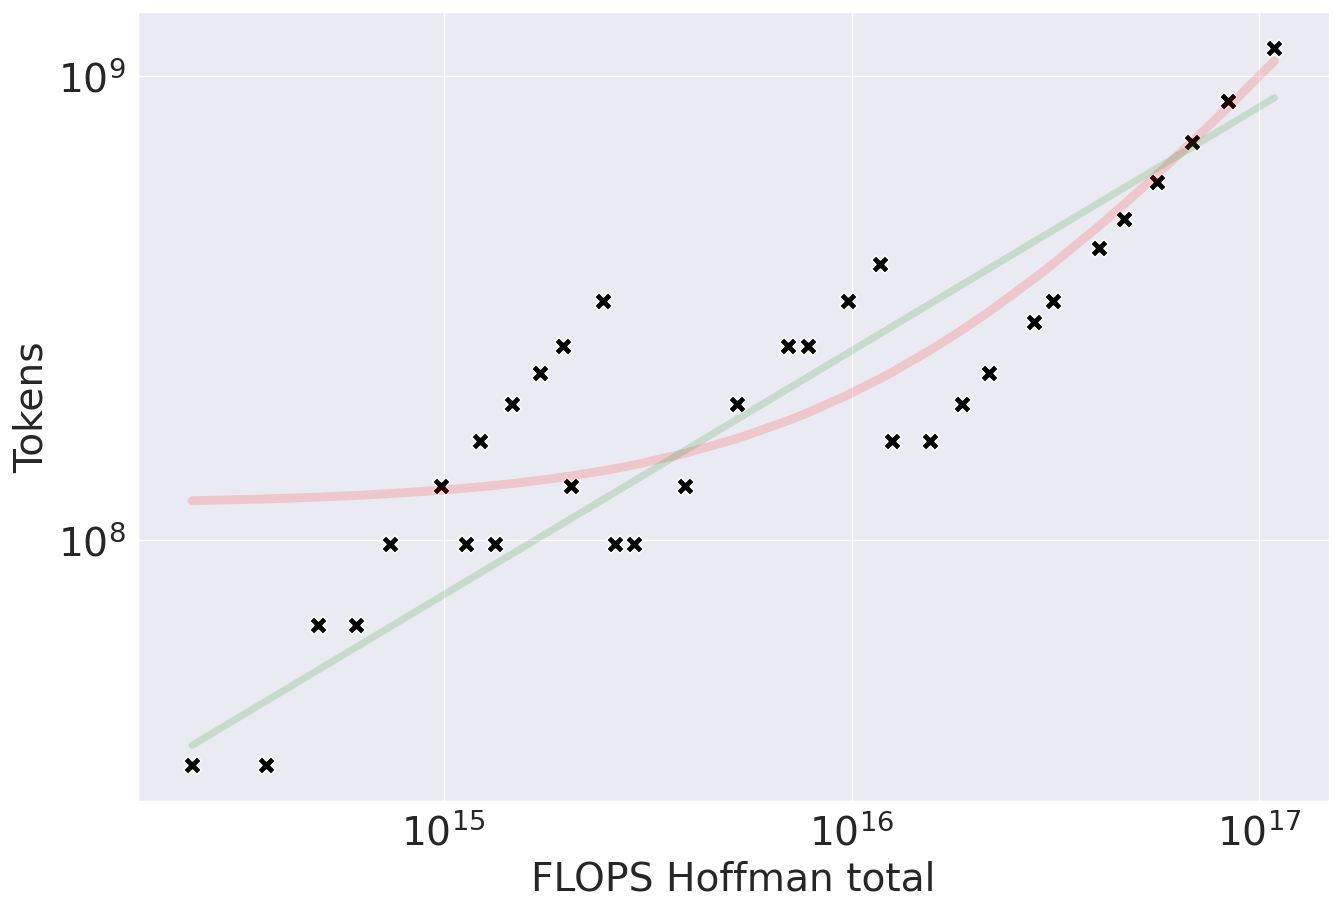

In [39]:
df_viz_fit(
    df_in=df_arg_min, 
    x_feature="FLOPS Hoffman total", 
    y_feature="Tokens",
)

Power parameters: [0.42266787],  Power R2: 0.7655651215457966
Line parameters: [-1.20851435e-10  3.68052726e+06], Line R2: 0.525169983234913


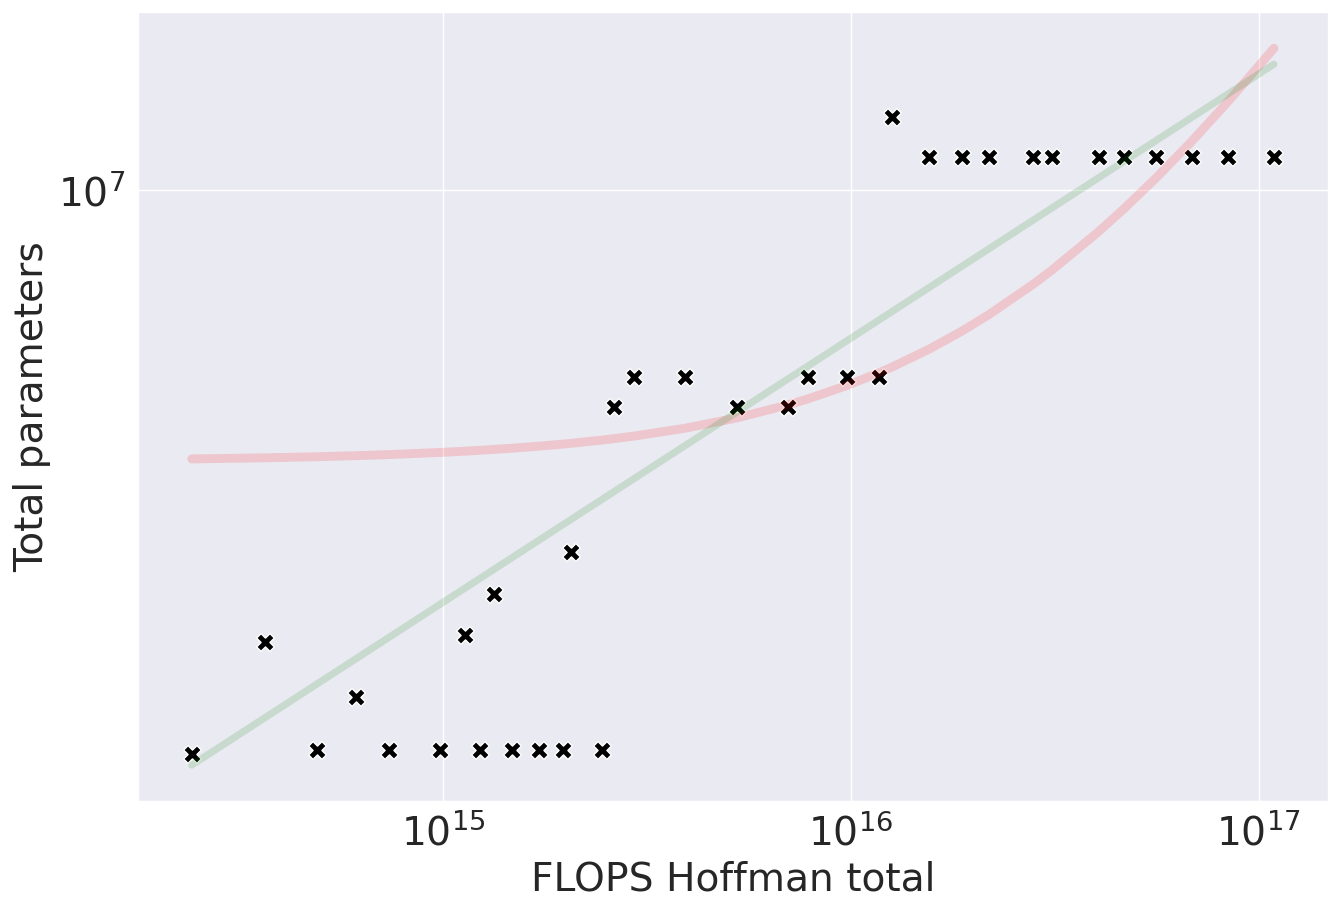

In [40]:
df_viz_fit(
    df_in=df_arg_min, 
    x_feature="FLOPS Hoffman total", 
    y_feature="Total parameters",
)

Power parameters: [0.07177604],  Power R2: -0.31078146195079137
Line parameters: [2.35944713e-16 1.95679363e+01], Line R2: 0.3190438725206015


/home/vdeshpande/miniconda3/envs/vlad_work/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


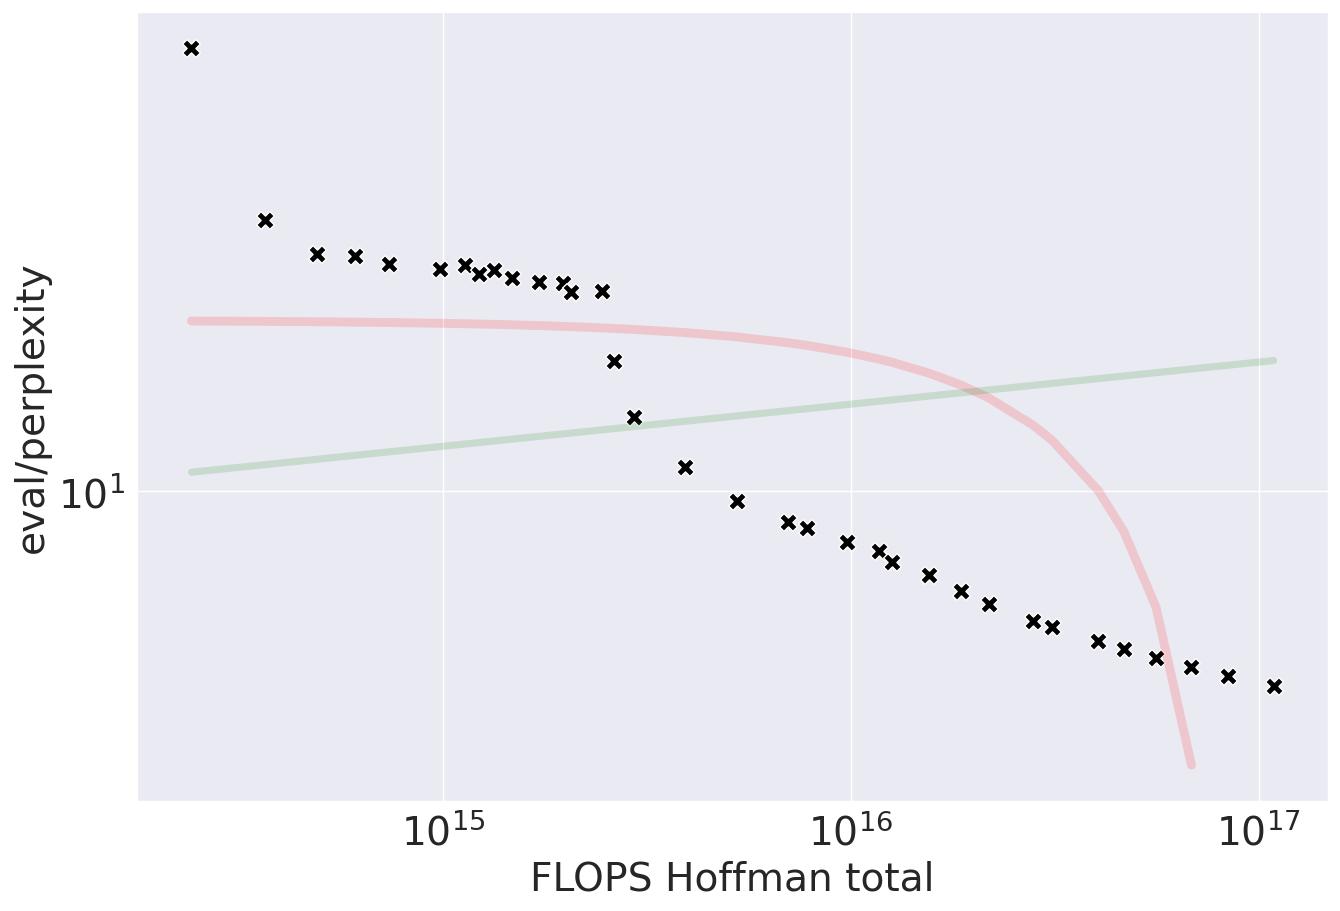

In [41]:
df_viz_fit(
    df_in=df_arg_min, 
    x_feature="FLOPS Hoffman total",
    y_feature="eval/perplexity",
)

In [93]:
!pwd

/home/vdeshpande/from_inanna/mini_bert/CSV files with experiment results
